<a href="https://colab.research.google.com/github/setthawut8/ai/blob/main/%5BBinary%20Text%20Classification%5D%20downsampling_stackingModels(ensemble).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library and Installtion

In [1]:
!pip install fairseq
!pip install pythainlp
!pip install sacremoses
!pip install transformers
!pip install sentencepiece
!pip install tensorflow-text
!gdown --id 1qYr5xKf3v31DWqLYu4OnNGfCIjmQamLJ
!gdown --id 16q3RKJJEWT5XcsNgfHNn2uVCy1FDNve4

     |████████████████████████████████| 511.7 MB 5.7 kB/s 
     |████████████████████████████████| 1.6 MB 94.0 MB/s 
     |████████████████████████████████| 5.8 MB 86.3 MB/s 
     |████████████████████████████████| 438 kB 78.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninst

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from pythainlp.translate import Translate


from pythainlp.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [3]:
train = pd.read_excel('/content/SET_Filtering_preprocessed_train_sampling1898_20220622.xlsx', engine='openpyxl')
test = pd.read_excel('/content/SET_Filtering_preprocessed_test_sampling335_20220622.xlsx', engine='openpyxl')

In [4]:
print(train.shape)
train.head(2)

(1898, 4)


,verbatim_id,verbatim,Filtering,Text_ws_local
0,524121789376412_397916622205355,กำไร bitkub ดีต่อหุ้นของ bitkub ไม่ใช่เหรียญ k...,Relevant,กำไร| |bitkub| |ดี|ต่อ|หุ้น|ของ| |bitkub| |ไม่...
1,1520537844074577921,HUG available at @foundation! Reserve price 0...,Relevant,hug| |available| |at| |friendtag| |reserve| |p...


In [5]:
print(test.shape)
test.head(2)

(335, 4)


,verbatim_id,verbatim,Filtering,Text_ws_local
0,807226112695347_5274973905920523,เอาใจสายคริปโตฯ กับ 3 Missions สุดคุ้ม❗ ⛱ Tun...,Not relevant,เอาใจ|สาย|ค|ริ|ป|โต|ฯ| |กับ| |3| |missions| |ส...
1,news,บลจ. ขาย IPO กองทุนเปิด วี เฟล็กซิเบิ้ล พร็อพเ...,Relevant,บริษัทหลักทรัพย์จัดการกองทุนรวมจำกัด| |ขาย| |i...


In [6]:
df_combined = pd.concat([train, test], axis=0)
print(df_combined.shape)
df_combined.head(5)

(2233, 4)


,verbatim_id,verbatim,Filtering,Text_ws_local
0,524121789376412_397916622205355,กำไร bitkub ดีต่อหุ้นของ bitkub ไม่ใช่เหรียญ k...,Relevant,กำไร| |bitkub| |ดี|ต่อ|หุ้น|ของ| |bitkub| |ไม่...
1,1520537844074577921,HUG available at @foundation! Reserve price 0...,Relevant,hug| |available| |at| |friendtag| |reserve| |p...
2,1520538394874777600,“LIL GIRL - PRESENT” for sale on @foundation! ...,Relevant,lil| |girl| |-| |present| |for| |sale| |on| |f...
3,89c2f93fd738a9f676f1748fe7e6ab4d_,รัสเซียเมื่อวันเสาร์ (30 เม.ย.) คาดว่าการไหลเว...,Relevant,รัสเซีย|เมื่อ|วันเสาร์| |30| |เม.ย.| |คาด|ว่าก...
4,323296631123627_5130144927105416,“เอสซีจี เคมิคอลส์” หรือ SCGC มั่นใจในศักยภาพธ...,Relevant,|เอ|ส|ซี|จี| |เค|มิ|คอ|ล|ส|์| |หรือ| |scgc| |...


In [7]:
df_combined['Text_ws_local'].iloc[0].replace("|", "")

'กำไร bitkub ดีต่อหุ้นของ bitkub ไม่ใช่เหรียญ kub เดาว่าในอนาคต bitkub จะเอาหุ้นเข้าตลาดหุ้น ซึ่ง scbx ซื้อไปจะได้กำไรตรงส่วนนี้มหาศาล'

#EDA

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1898 entries, 0 to 1897
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   verbatim_id    1898 non-null   object
 1   verbatim       1898 non-null   object
 2   Filtering      1898 non-null   object
 3   Text_ws_local  1898 non-null   object
dtypes: object(4)
memory usage: 59.4+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   verbatim_id    335 non-null    object
 1   verbatim       335 non-null    object
 2   Filtering      335 non-null    object
 3   Text_ws_local  335 non-null    object
dtypes: object(4)
memory usage: 10.6+ KB


Relevant        1429
Not relevant     804
Name: Filtering, dtype: int64


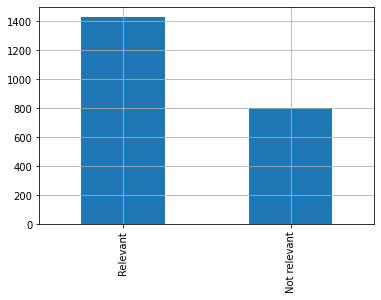

In [10]:
print(df_combined['Filtering'].value_counts())
df_combined['Filtering'].value_counts().sort_values(ascending=False).plot(kind='bar', grid=True)

##Downsampling

In [11]:
df_relevant = df_combined[df_combined['Filtering']=='Relevant']
df_irrelevant = df_combined[df_combined['Filtering']=='Not relevant']

In [12]:
print(df_relevant.shape)
df_relevant.head(2)

(1429, 4)


,verbatim_id,verbatim,Filtering,Text_ws_local
0,524121789376412_397916622205355,กำไร bitkub ดีต่อหุ้นของ bitkub ไม่ใช่เหรียญ k...,Relevant,กำไร| |bitkub| |ดี|ต่อ|หุ้น|ของ| |bitkub| |ไม่...
1,1520537844074577921,HUG available at @foundation! Reserve price 0...,Relevant,hug| |available| |at| |friendtag| |reserve| |p...


In [13]:
print(df_irrelevant.shape)
df_irrelevant.head(2)

(804, 4)


,verbatim_id,verbatim,Filtering,Text_ws_local
15,5126778170740124_5127744550643486,ขอให้ข้าพเจ้ามีทางปลดหนี้,Not relevant,ขอให้|ข้าพเจ้า|มี|ทาง|ปลดหนี้
18,1520649421154766849,ก็เกาะขอบเวทีอะครับ #MetaWarden #MetaWardenNF...,Not relevant,ก็|เกาะ|ขอบ|เวที|อะ|ครับ| |metawarden| |metawa...


In [14]:
 df_relevant_sampled = df_relevant.sample(df_irrelevant.shape[0])
 df_combined = pd.concat([df_relevant_sampled, df_irrelevant])
 df_combined['Filtering'].value_counts()

Relevant        804
Not relevant    804
Name: Filtering, dtype: int64

In [15]:
df_combined['label'] = df_combined['Filtering'].apply(lambda x: 1 if x=='Relevant' else 0)
df_combined

,verbatim_id,verbatim,Filtering,Text_ws_local,label
181,1295271571005448_412735406955959,อืมๆ แค่มุมมองนึง ก็ย่อมมีเหตุผลส่วนตัวอยู่ในใ...,Relevant,อืมๆ| |แค่|มุมมอง|นึง| |ก็|ย่อม|มีเหตุผล|ส่วนต...,1
205,128567713887938_5082731871804806,แนะนำลงทุนในกองทุนรวมหุ้นจีน - หุ้นเวียดนามที่...,Relevant,แนะนำ|ลงทุน|ใน|กองทุนรวม|หุ้น|จีน| |-| |หุ้น|เ...,1
288,Ugy5grINenZvAUJw9Gt4AaABAg,เพราะแบบนี้ไงครับ bitcoin คริปโต ถึงมีค่าขึ้นมาก,Relevant,เพราะ|แบบนี้|ไง|ครับ| |bitcoin| |ค|ริ|ป|โต| |ถ...,1
1748,163442564370285_979944356053431,"เสี่่ยกึ้งพารักเรือล่ม,3ค่ายมือดังกอดคอร่วง,แบ...",Relevant,เสี่ย|กึ้ง|พา|รัก|เรือ|ล่ม| |3| |ค่าย|มือ|ดัง|...,1
234,322703134512182_5174330096016104,-ถึง...คุณ คนที่มีความพยายาม...จนไม่เป็นตัวเอง...,Relevant,-| |ถึง|คุณ| |คน|ที่|มี|ความพยายาม|จน|ไม่|เป็น...,1
...,...,...,...,...,...
324,101345495409094_311486557728319,(ข่าวคริปโตล่าสุด) จุดเริ่มต้น DOGECOIN จะ กลั...,Not relevant,ข่าว|ค|ริ|ป|โต|ล่าสุด| |จุดเริ่มต้น| |dogecoin...,0
329,1107366626609179_1837811293075689,ร่วมทำบุญค่ะ,Not relevant,ร่วม|ทำบุญ|ค่ะ,0
331,48e408dd24d91f3856a4719a060d9859_,มิติหุ้น – เมื่อ 5 พ.ค. 2565 ที่ผ่านมา สภาหอกา...,Not relevant,มิติ|หุ้น| |เมื่อ| |5| |พ|.|ค.| |2565| |ที่ผ่า...,0
332,170270130112516_1415329162273267,แล้วคุณล่ะ เป็นหนึ่งในนั้นหรือไม่?,Not relevant,แล้ว|คุณ|ล่ะ| |เป็นหนึ่ง|ใน|นั้น|หรือไม่|,0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_combined['Text_ws_local'], df_combined['label'], stratify=df_combined['label'])

#Model

##Bags of Words

In [17]:
ws_tfidf = TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1,2), sublinear_tf=True)
ws_vec = ws_tfidf.fit_transform(X_train)
ws_vec_test = ws_tfidf.transform(X_test)

##Stacking Model

In [27]:
estimators = [
              ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
              ('svc', LinearSVC(random_state=42)),
              ('knn', KNeighborsClassifier(n_neighbors=15)),
              ('lgr', LogisticRegression(random_state=42))
]

clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42),
    n_jobs=-1,
    verbose=2,
    cv=5
)

clf.fit(ws_vec, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svc', LinearSVC(random_state=42)),
                               ('knn', KNeighborsClassifier(n_neighbors=15)),
                               ('lgr', LogisticRegression(random_state=42))],
                   final_estimator=LogisticRegression(random_state=42),
                   n_jobs=-1, verbose=2)

In [30]:
preds = clf.predict(ws_vec_test)

#Post Analysis

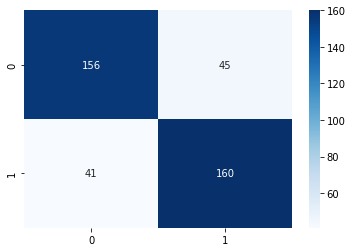

In [33]:
conf_mat = confusion_matrix(y_test,preds)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

In [34]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78       201
           1       0.78      0.80      0.79       201

    accuracy                           0.79       402
   macro avg       0.79      0.79      0.79       402
weighted avg       0.79      0.79      0.79       402

